# About Dataset

## Content:

The data belongs to Lloyds Banking, the largest retail bank in the uk. 

This dataset consists of 18,324 customers who:  

➢ Previously held a loan  

➢ The status of that loan- did the customer pay back the loan or not:  
- Customers who paid back are categorised as 'Fully Paid'  
- Customers who did not pay back their loan are categorised as 'Charged-off'  

➢ Other credit and product information that can be used to understand a customer's credit or financial behaviour

## Task

The objective of this task is the create a model predicting the likelihood of a customer paying back their loan

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import optuna
import mlflow


In [10]:
base_path = Path.cwd().parent/"data"/"raw"
file_path = base_path/"LBG Step Up Data Set.xlsx"
df = pd.read_excel(file_path)
print(f'Number of rows: {df.shape[0]} \nnumber of columns: {df.shape[1]}')

Number of rows: 18324 
number of columns: 31


In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [13]:
df.head()

,id,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status
0,802173,CA,72000.0,3 years,CA. Dept. Of Corrections,MORTGAGE,395.66,12000,debt_consolidation,36 months,0.1149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,0,23,NaN,Fully Paid
1,14518910,TX,97500.0,1 year,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,60 months,0.2199,7019.0,NaN,NaN,148.0,170.0,28.0,9.0,4.0,NaN,14.0,2.0,12.0,0.0,1.0,13,87.5,0,24,84227.0,Fully Paid
2,54333324,NY,120000.0,1 year,Senior manager,RENT,806.57,25000,credit_card,36 months,0.0999,4891.0,NaN,NaN,128.0,147.0,80.0,11.0,0.0,53.0,11.0,2.0,7.0,0.0,1.0,8,100.0,0,16,39124.0,Fully Paid
3,62247022,CA,130000.0,10+ years,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,36 months,0.1269,17619.0,NaN,NaN,130.0,172.0,68.0,2.0,4.0,41.0,9.0,9.0,3.0,0.0,2.0,8,50.0,0,24,123331.0,Fully Paid
4,71986114,TX,58296.0,10+ years,Account Manager,MORTGAGE,41.79,1200,other,36 months,0.1531,12321.0,1.0,10372.0,167.0,145.0,18.0,18.0,1.0,NaN,7.0,7.0,6.0,0.0,0.0,9,100.0,0,17,51794.0,Fully Paid


In [14]:
df.describe(include="all")

,id,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status
count,1.832400e+04,18324,1.832400e+04,17150,17042,18324,18324.000000,18324.000000,18324,18324,18324.000000,17758.000000,9395.000000,9395.000000,17192.000000,17760.000000,17760.000000,17760.000000,17926.000000,9276.000000,17760.000000,17760.000000,17760.000000,17760.000000,17760.000000,18324.000000,17714.000000,18324.000000,18324.000000,1.792600e+04,18324
unique,NaN,51,NaN,11,10040,5,NaN,NaN,14,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,CA,NaN,10+ years,Teacher,MORTGAGE,NaN,NaN,debt_consolidation,36 months,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
freq,NaN,2667,NaN,6204,279,8880,NaN,NaN,10678,13120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14418
mean,6.832645e+07,NaN,8.017611e+04,NaN,NaN,NaN,467.543006,15522.661537,NaN,NaN,0.138507,13466.600011,2.301863,5728.533475,125.348127,180.750788,13.077534,7.793131,1.626799,34.364705,7.964752,8.575619,8.268525,0.086092,2.274775,11.629284,45.489228,0.142054,24.750109,5.148915e+04,NaN
std,4.245703e+07,NaN,6.487345e+04,NaN,NaN,NaN,278.099801,9349.294243,NaN,NaN,0.048223,16550.730832,2.523087,5628.027589,52.996782,95.122321,16.500588,8.911026,1.993844,22.047538,4.847990,7.372691,4.627181,0.440718,1.936068,5.578496,35.907408,0.388198,12.192517,4.970348e+04,NaN
min,3.009180e+05,NaN,3.000000e+03,NaN,NaN,NaN,30.650000,1000.000000,NaN,NaN,0.053100,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,NaN
25%,3.491424e+07,NaN,4.700000e+04,NaN,NaN,NaN,259.302500,8000.000000,NaN,NaN,0.104900,3129.000000,1.000000,2170.500000,97.000000,116.000000,4.000000,3.000000,0.000000,16.000000,4.000000,3.000000,5.000000,0.000000,1.000000,8.000000,12.500000,0.000000,16.000000,2.151850e+04,NaN
50%,6.838023e+07,NaN,6.500000e+04,NaN,NaN,NaN,397.480000,14000.000000,NaN,NaN,0.133300,7137.000000,2.000000,4244.000000,129.000000,164.000000,8.000000,5.000000,1.000000,31.000000,7.000000,7.000000,7.000000,0.000000,2.000000,11.000000,44.400000,0.000000,23.000000,3.897700e+04,NaN
75%,9.730784e+07,NaN,9.500000e+04,NaN,NaN,NaN,635.720000,21000.000000,NaN,NaN,0.169900,18436.500000,3.000000,7357.000000,152.000000,231.000000,16.000000,10.000000,3.000000,50.000000,10.000000,11.000000,11.000000,0.000000,3.000000,14.000000,75.000000,0.000000,32.000000,6.526700e+04,NaN


- based on the .describe, we can see that some categorical variables have large number of categroies like the `addr_state`
- for those that only have 2 (binary) let's just replace by 0 and 1 
- for those that have more than 2, we will use either one-hot encoding or target encoding

In [15]:
df.isna().sum()

id                           0
addr_state                   0
annual_inc                   0
emp_length                1174
emp_title                 1282
home_ownership               0
installment                  0
loan_amnt                    0
purpose                      0
term                         0
int_rate                     0
avg_cur_bal                566
inq_last_12m              8929
max_bal_bc                8929
mo_sin_old_il_acct        1132
mo_sin_old_rev_tl_op       564
mo_sin_rcnt_rev_tl_op      564
mo_sin_rcnt_tl             564
mort_acc                   398
mths_since_last_delinq    9048
num_bc_tl                  564
num_il_tl                  564
num_op_rev_tl              564
num_tl_90g_dpd_24m         564
num_tl_op_past_12m         564
open_acc                     0
percent_bc_gt_75           610
pub_rec_bankruptcies         0
total_acc                    0
total_bal_ex_mort          398
loan_status                  0
dtype: int64

# Data Cleaning

In [16]:
# Drop id column
df.drop(columns=['id'], inplace=True)


# clean and transform Emp Length
emp_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}
df['emp_length'] = df['emp_length'].map(emp_map).fillna(-1)

num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].fillna(-1)


# Feature Engineering

In [17]:
# How much of their annual income is already tied up in non-mortgage debt?
df['debt_to_income_stress'] = df['total_bal_ex_mort'] / df['annual_inc']

# How much of their annual salary is this loan?
df['loan_to_income_ratio'] = df['loan_amnt'] / (df['annual_inc'] + 1)

# Monthly installment vs monthly income
df['installment_to_inc'] = df['installment'] / (df['annual_inc'] / 12)

# Flag for high credit card utilization
df['is_high_utilization'] = (df['percent_bc_gt_75'] > 75).astype(int)

# Disposable Income Estimate: What is left over for the borrower to live on?
df['disposable_inc_estimate'] = (df['annual_inc'] / 12) - df['installment']

In [18]:
df.head()

,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status,debt_to_income_stress,loan_to_income_ratio,installment_to_inc,is_high_utilization,disposable_inc_estimate
0,CA,72000.0,3.0,CA. Dept. Of Corrections,MORTGAGE,395.66,12000,debt_consolidation,36 months,0.1149,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16,-1.0,0,23,-1.0,Fully Paid,-0.000014,0.166664,0.065943,0,5604.340000
1,TX,97500.0,1.0,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,60 months,0.2199,7019.0,-1.0,-1.0,148.0,170.0,28.0,9.0,4.0,-1.0,14.0,2.0,12.0,0.0,1.0,13,87.5,0,24,84227.0,Fully Paid,0.863867,0.358971,0.118950,1,7158.530000
2,NY,120000.0,1.0,Senior manager,RENT,806.57,25000,credit_card,36 months,0.0999,4891.0,-1.0,-1.0,128.0,147.0,80.0,11.0,0.0,53.0,11.0,2.0,7.0,0.0,1.0,8,100.0,0,16,39124.0,Fully Paid,0.326033,0.208332,0.080657,1,9193.430000
3,CA,130000.0,10.0,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,36 months,0.1269,17619.0,-1.0,-1.0,130.0,172.0,68.0,2.0,4.0,41.0,9.0,9.0,3.0,0.0,2.0,8,50.0,0,24,123331.0,Fully Paid,0.948700,0.194037,0.078108,0,9987.163333
4,TX,58296.0,10.0,Account Manager,MORTGAGE,41.79,1200,other,36 months,0.1531,12321.0,1.0,10372.0,167.0,145.0,18.0,18.0,1.0,-1.0,7.0,7.0,6.0,0.0,0.0,9,100.0,0,17,51794.0,Fully Paid,0.888466,0.020584,0.008602,1,4816.210000


# Binary encoding 

In [19]:
# Binary categorical column (2 unique values)
binary_cols = ['term', 'loan_status']


# Map Fully Paid/Charged Off and 36 months/60 months to 0/1
df[binary_cols] = df[binary_cols].replace({
    'Fully Paid' : 0, 'Charged Off': 1,
    ' 36 months': 0, ' 60 months': 1,
})

df.head()

,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status,debt_to_income_stress,loan_to_income_ratio,installment_to_inc,is_high_utilization,disposable_inc_estimate
0,CA,72000.0,3.0,CA. Dept. Of Corrections,MORTGAGE,395.66,12000,debt_consolidation,0,0.1149,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16,-1.0,0,23,-1.0,0,-0.000014,0.166664,0.065943,0,5604.340000
1,TX,97500.0,1.0,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,1,0.2199,7019.0,-1.0,-1.0,148.0,170.0,28.0,9.0,4.0,-1.0,14.0,2.0,12.0,0.0,1.0,13,87.5,0,24,84227.0,0,0.863867,0.358971,0.118950,1,7158.530000
2,NY,120000.0,1.0,Senior manager,RENT,806.57,25000,credit_card,0,0.0999,4891.0,-1.0,-1.0,128.0,147.0,80.0,11.0,0.0,53.0,11.0,2.0,7.0,0.0,1.0,8,100.0,0,16,39124.0,0,0.326033,0.208332,0.080657,1,9193.430000
3,CA,130000.0,10.0,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,0,0.1269,17619.0,-1.0,-1.0,130.0,172.0,68.0,2.0,4.0,41.0,9.0,9.0,3.0,0.0,2.0,8,50.0,0,24,123331.0,0,0.948700,0.194037,0.078108,0,9987.163333
4,TX,58296.0,10.0,Account Manager,MORTGAGE,41.79,1200,other,0,0.1531,12321.0,1.0,10372.0,167.0,145.0,18.0,18.0,1.0,-1.0,7.0,7.0,6.0,0.0,0.0,9,100.0,0,17,51794.0,0,0.888466,0.020584,0.008602,1,4816.210000


# One-Hot encoding

In [20]:
# Categorical columns with more than 2 unique values
multi_cat_cols = [
    'home_ownership', 'purpose'
]

# One-hot encode
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

df.head()

,addr_state,annual_inc,emp_length,emp_title,installment,loan_amnt,term,int_rate,avg_cur_bal,inq_last_12m,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status,debt_to_income_stress,loan_to_income_ratio,installment_to_inc,is_high_utilization,disposable_inc_estimate,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,CA,72000.0,3.0,CA. Dept. Of Corrections,395.66,12000,0,0.1149,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16,-1.0,0,23,-1.0,0,-0.000014,0.166664,0.065943,0,5604.340000,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,TX,97500.0,1.0,Curriculum & Implementation Manager,966.47,35000,1,0.2199,7019.0,-1.0,-1.0,148.0,170.0,28.0,9.0,4.0,-1.0,14.0,2.0,12.0,0.0,1.0,13,87.5,0,24,84227.0,0,0.863867,0.358971,0.118950,1,7158.530000,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2,NY,120000.0,1.0,Senior manager,806.57,25000,0,0.0999,4891.0,-1.0,-1.0,128.0,147.0,80.0,11.0,0.0,53.0,11.0,2.0,7.0,0.0,1.0,8,100.0,0,16,39124.0,0,0.326033,0.208332,0.080657,1,9193.430000,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,CA,130000.0,10.0,Border Patrol Agent,846.17,25225,0,0.1269,17619.0,-1.0,-1.0,130.0,172.0,68.0,2.0,4.0,41.0,9.0,9.0,3.0,0.0,2.0,8,50.0,0,24,123331.0,0,0.948700,0.194037,0.078108,0,9987.163333,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4,TX,58296.0,10.0,Account Manager,41.79,1200,0,0.1531,12321.0,1.0,10372.0,167.0,145.0,18.0,18.0,1.0,-1.0,7.0,7.0,6.0,0.0,0.0,9,100.0,0,17,51794.0,0,0.888466,0.020584,0.008602,1,4816.210000,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


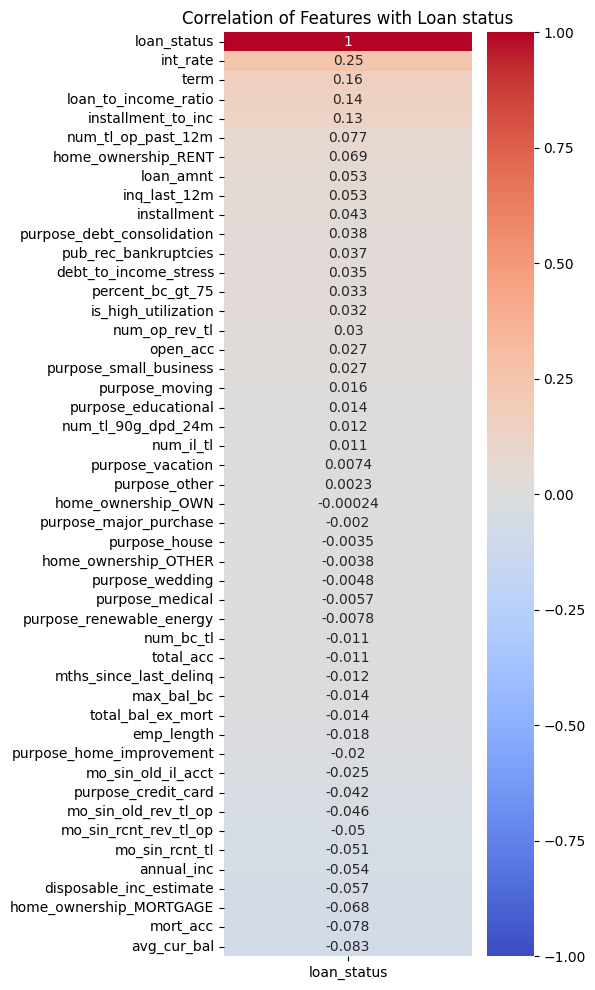

In [21]:
# Compute correlation matrix only for numeric columns
corr_matrix = df.corr(numeric_only=True)

# Focus on correlation with loan status
loan_corr = corr_matrix[['loan_status']].sort_values(by='loan_status', ascending=False)

# Plot heatmap
plt.figure(figsize=(4,12))
sns.heatmap(loan_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Loan status')
plt.show()

# Data splitting

In [22]:
# Prepare data
X = df.drop(columns=['loan_status'])
y = df['loan_status']

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18324 entries, 0 to 18323
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   addr_state                  18324 non-null  object 
 1   annual_inc                  18324 non-null  float64
 2   emp_length                  18324 non-null  float64
 3   emp_title                   17042 non-null  object 
 4   installment                 18324 non-null  float64
 5   loan_amnt                   18324 non-null  int64  
 6   term                        18324 non-null  int64  
 7   int_rate                    18324 non-null  float64
 8   avg_cur_bal                 18324 non-null  float64
 9   inq_last_12m                18324 non-null  float64
 10  max_bal_bc                  18324 non-null  float64
 11  mo_sin_old_il_acct          18324 non-null  float64
 12  mo_sin_old_rev_tl_op        18324 non-null  float64
 13  mo_sin_rcnt_rev_tl_op       183

# Target Encoder

In [24]:
# Categorical columns with over 15 variables
target_multi_cat_cols = [
    'addr_state', 'emp_title'
]

te = TargetEncoder(cols=target_multi_cat_cols)

In [25]:
df.select_dtypes(include=['object']).head()

,addr_state,emp_title
0,CA,CA. Dept. Of Corrections
1,TX,Curriculum & Implementation Manager
2,NY,Senior manager
3,CA,Border Patrol Agent
4,TX,Account Manager


# Look for multicolinearity (VIF)

In [26]:
def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])
    
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
    numeric_df = numeric_df.dropna() # Drop rows with any NaN
    
    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data['feature'] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)
        for i in range(len(numeric_df.columns))
    ]
    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

# Read the original file 
df = pd.read_excel(file_path)
vif_table = calculate_vif(df, target_col="loan_status")
print(vif_table)

                   feature        VIF
0                loan_amnt  13.488109
1              installment  13.078448
2                total_acc  10.825738
3                num_il_tl   6.793260
4            num_op_rev_tl   6.772865
5                 open_acc   5.579811
6                num_bc_tl   3.294743
7       num_tl_op_past_12m   1.930251
8        total_bal_ex_mort   1.911252
9                 mort_acc   1.868559
10          mo_sin_rcnt_tl   1.777370
11   mo_sin_rcnt_rev_tl_op   1.649254
12             avg_cur_bal   1.646501
13              max_bal_bc   1.504695
14            inq_last_12m   1.348807
15              annual_inc   1.328798
16    mo_sin_old_rev_tl_op   1.305910
17        percent_bc_gt_75   1.278834
18                int_rate   1.244526
19      mo_sin_old_il_acct   1.174248
20  mths_since_last_delinq   1.107608
21      num_tl_90g_dpd_24m   1.089558
22                      id   1.063957
23    pub_rec_bankruptcies   1.045711


- Clearly we can see there's multicolinearity between features 
- Tree based models like XGBoost or LightGBM are less sensitive to multicolinearity, thus we can keep these columns.

# Machine learning

In [27]:
df['loan_status'].value_counts()

loan_status
Fully Paid     14418
Charged Off     3906
Name: count, dtype: int64

Since we are predicting whether or not a borrower will default on their loan (loan_status), the "cost" of making a mistake is highly asymmetric. We prioritize Recall (and metrics like the F1-Score) over simple accuracy.  

The Asymmetric Cost of Lending:  
- False Negative (FN): You predict a borrower will pay back (Fully Paid), but they actually Default.

- Business Impact: High. The bank loses the unpaid principal (e.g., £10,000+). This is the most expensive mistake.

- False Positive (FP): You predict a borrower will Default, but they would have Paid Back.

- Business Impact: Low to Moderate. The bank loses the potential interest income (e.g., £500 - £1,000) because they rejected a good customer.

- Conclusion: Missing a defaulter (FN) is significantly more costly than wrongly rejecting a good applicant (FP).



# RandomForest classifier (Base Model)

In [28]:
# Create the LGBM model
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

pipe_rf = Pipeline([
    ('encoder', te),
    ('classifier', rf)
])

scores = cross_val_score(
    estimator=pipe_rf,
    X=X_train,
    y=y_train,
    scoring="recall",
    cv=5, 
    n_jobs=-1
)

# Print individual CV scores
print(f'CV Recall scores: {scores}')
print('=' * 50)
# Print mean and standard deviation of CV scores
print(f'CV Mean Recall: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV Recall scores: [0.1152 0.1152 0.0992 0.128  0.1216]
CV Mean Recall: 0.116 +/- 0.010


# LightGBM classifier

In [29]:
# Create the LGBM model
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

pipe_lgbm = Pipeline([
    ('encoder', te),
    ('classifier', lgbm)
])

scores = cross_val_score(
    estimator=pipe_lgbm,
    X=X_train,
    y=y_train,
    scoring="recall",
    cv=5, 
    n_jobs=-1
)

# Print individual CV scores
print(f'CV Recall scores: {scores}')
print('=' * 50)
# Print mean and standard deviation of CV scores
print(f'CV Mean Recall: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV Recall scores: [0.2896 0.28   0.3408 0.2976 0.3232]
CV Mean Recall: 0.306 +/- 0.022


We are catching 31% of customers who don't pay their loans.

# XGBoost Classifier

In [30]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.5,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

pipe_xgboost = Pipeline([
    ('encoder', te),
    ('classifier', xgb)
])

scores = cross_val_score(
    estimator=pipe_xgboost,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

# Print individual CV scores
print(f'CV Recall scores: {scores}')
print('=' * 50)
# Print mean and standard deviation of CV scores
print(f'CV Mean Recall: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV Recall scores: [0.2288 0.2464 0.2144 0.2256 0.2208]
CV Mean Recall: 0.227 +/- 0.011


- Based on the results of these two models, LightGBM performs better before tuning, thus it will be used as our model.

# Hyperparameter Tuning (Optuna) & Experiment Tracking (MLFlow)

In [31]:
# Objective function for Optuna
def objective(trial):
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000), 
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "importance_type": "gain",
        "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
        
    }

    

    with mlflow.start_run(nested=True):
        model = LGBMClassifier(**params)
        pipe_lgbm = Pipeline([
            ('encoder', te),
            ('classifier', model)
        ])

        cv_scores = cross_val_score(pipe_lgbm,
                                    X_train,
                                    y_train,
                                    cv = 5,
                                    scoring="recall",
                                    n_jobs=-1)
        
        avg_recall = cv_scores.mean()

        # log hyperparameters + metrics
        mlflow.log_params(params)
        mlflow.log_metrics({"recall" : avg_recall})
    
    return avg_recall


path = Path.cwd().parent/"mlruns"

mlflow.set_tracking_uri(path)
mlflow.set_experiment("lgbm_optuna_loan")


# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Params:", study.best_params)
print("Best Recall:", study.best_value)

e:\Projects\Lloyd Bank\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/06 13:01:59 INFO mlflow.tracking.fluent: Experiment with name 'lgbm_optuna_loan' does not exist. Creating a new experiment.
[I 2026-02-06 13:01:59,373] A new study created in memory with name: no-name-b38156ec-5c31-4f8e-bef7-e77471a246b9
[I 2026-02-06 13:02:15,646] Trial 0 finished with value: 0.19615999999999997 and parameters: {'n_estimators': 695, 'learning_rate': 0.11689753402229841, 'max_depth': 11, 'num_leaves': 456, 'subsample': 0.5663509

Best Params: {'n_estimators': 369, 'learning_rate': 0.010101869191631432, 'max_depth': 4, 'num_leaves': 926, 'subsample': 0.6060047989710078, 'colsample_bytree': 0.6094638880925793, 'min_child_samples': 61, 'reg_alpha': 8.469388573700552e-08, 'reg_lambda': 5.2911768255575715e-05}
Best Recall: 0.5936


In [32]:
fixed_params = {
    "random_state": 42,
    "n_jobs": -1,
    "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
    "importance_type": "gain",
    "verbosity": -1
}

# Merge fixed params with the best suggested params from Optuna
final_params = {**fixed_params, **study.best_params}

# Re-initialize the model and the Pipeline
best_model = LGBMClassifier(**final_params)


pipe_lgbm = Pipeline([
    ('encoder', te),
    ('classifier', best_model)
])

pipe_lgbm.fit(X_train, y_train)

# Prediction
proba = pipe_lgbm.predict_proba(X_test)[:, 1]
y_pred = pipe_lgbm.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
auc = roc_auc_score(y_test, proba)

print("Final tuned model performance:")
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)
print("auc:", auc)

# log final model
with mlflow.start_run(run_name="best_lgbm_model"):
    mlflow.log_params(final_params)
    mlflow.log_metrics({"precision": precision, "recall" : recall, "f1" : f1, "auc": auc})
    mlflow.sklearn.log_model(sk_model=pipe_lgbm, artifact_path="model_pipeline")
    

2026/02/06 13:04:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Final tuned model performance:
precision: 0.3127809890815671
recall: 0.6235595390524968
f1: 0.41659538066723695
auc: 0.6544447621297067


e:\Projects\Lloyd Bank\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/06 13:04:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


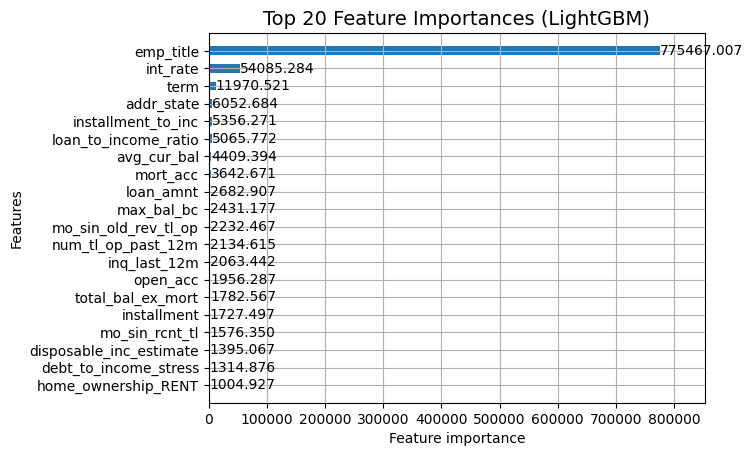

In [33]:
from lightgbm import plot_importance
plot_importance(
    best_model, 
    importance_type="gain",
    max_num_features=20,
    height=0.5
)

plt.title("Top 20 Feature Importances (LightGBM)", fontsize=14)
plt.show()

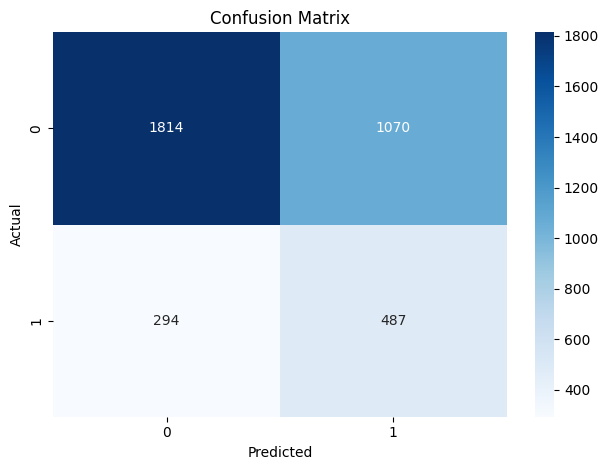

In [34]:
# Compute the confusion matrix 
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')



plt.tight_layout()
plt.show()